<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>Yoshihiro Shirai</center>
</h1>

<h1>
<center>Homework 1 Solution</center>
</h1>


# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [2]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [3]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 168 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [4]:
X_raw.shape

(16512, 9)

In [5]:
X_raw[X_raw.isnull().any(axis=1)].shape

(168, 9)

In [6]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

In [7]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
num_features = X_raw.drop("ocean_proximity", axis=1)
imputer.fit(num_features)

SimpleImputer(strategy='median')

- We can check that the values of the `imputer` correspond to the median of each column of our dataset

In [8]:
[imputer.statistics_,num_features.median().values]

[array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385]),
 array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385])]

- Apply the imputer `.tranform()` method to fill the missing values and store the result in a data frame.

In [9]:
temp = imputer.transform(num_features)
X_num = pd.DataFrame(temp, columns=num_features.columns)
X_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
1,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
2,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
3,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
4,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
16507,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
16508,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
16509,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
16510,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


- Finally, we can check that:
    - missing entries in the `total_bedrooms_` column are now replaced with the median value of that column (note that the rows have changed)
    - There are no missing entries in the `X_num` dataset

In [10]:
X_raw.loc[( (X_raw['longitude']==-120.67) & (X_raw['latitude']==40.50) )]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.5,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND


In [11]:
X_num.loc[( (X_num['longitude']==-120.67) & (X_num['latitude']==40.50) )]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
99,-120.67,40.5,15.0,5343.0,434.0,2503.0,902.0,3.5962


In [12]:
X_num[X_num.isnull().any(axis=1)].shape

(0, 8)

## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

In [13]:
X_raw['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7274
INLAND        5301
NEAR OCEAN    2089
NEAR BAY      1846
ISLAND           2
Name: count, dtype: int64

- We can obtain ordinal and one-hot encoding as follows.

In [14]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_encoder, onehot_encoder = OrdinalEncoder(),  OneHotEncoder()
X_cat_integer = ordinal_encoder.fit_transform(X_raw[['ocean_proximity']])
X_cat_1hot = onehot_encoder.fit_transform(X_raw[['ocean_proximity']])

- It is more appropriate to use one-hot encoding because using ordinal encoding will assume that two nearby values are more similar than two distant values, which is not necessarily the case for the ocean_proximity categories (NEAR OCEAN, <1H OCEAN, INLAND may be ordered, but it's not clear how NEAR BAY and ISLAND would fit into that ordering) One-hot encoding doesn't have this problem.

In [15]:
print(X_cat_integer[:10])
print(ordinal_encoder.categories_)

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [16]:
print(X_cat_1hot.toarray()[:10,:])
print(onehot_encoder.categories_)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [17]:
X_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [18]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log)
log_pop = log_transformer.transform(X_raw[["population"]])
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


- Creating the ratio `total_bedrooms/total_rooms` from the dataset after `total_bedrooms` is imputed.

In [19]:
from sklearn.pipeline import make_pipeline

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

ratio_pipeline = make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name))

bedrooms_ratio = ratio_pipeline.fit_transform(X_raw[["total_bedrooms", "total_rooms"]])
bedrooms_ratio

array([[0.33574225],
       [0.18015267],
       [0.20036934],
       ...,
       [0.19770408],
       [0.2308913 ],
       [0.45243619]], shape=(16512, 1))

- Alternatively, without a pipeline, it can be calculated directly

In [20]:
bedrooms_ratio = X_num["total_bedrooms"] / X_num["total_rooms"]

## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization. 

**Solution:**

In [21]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

It is acceptable to apply the standard scaler to `X_num` with or without the transformed features in (c). (It is only in (d) that requires all the steps to be combined). In this demostration, we do the latter.

In [22]:
X_num["population"] = log_pop
X_num["bedrooms_ratio"] = bedrooms_ratio
X_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_ratio
0,-122.42,37.80,52.0,3321.0,1115.0,5.774552,1034.0,2.0987,0.335742
1,-118.38,34.14,40.0,1965.0,354.0,7.783641,357.0,6.0876,0.180153
2,-121.98,38.36,33.0,1083.0,217.0,6.206576,203.0,2.4330,0.200369
3,-117.11,33.75,17.0,4174.0,851.0,6.324359,780.0,2.2618,0.203881
4,-118.15,33.77,36.0,4366.0,1211.0,6.336826,1172.0,3.5292,0.277371
...,...,...,...,...,...,...,...,...,...
16507,-118.40,33.86,41.0,2237.0,597.0,6.692084,523.0,4.7105,0.266875
16508,-119.31,36.32,23.0,2945.0,592.0,6.891626,532.0,2.5733,0.201019
16509,-117.06,32.59,13.0,3920.0,775.0,6.516193,760.0,4.0616,0.197704
16510,-118.40,34.06,37.0,3781.0,873.0,6.833032,838.0,4.1455,0.230891


In [23]:
X_num_std = pd.DataFrame(std_scaler.fit_transform(X_num),
                         columns=X_num.columns)

In [24]:
X_num_std.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_ratio
0,-1.423037,1.013606,1.861119,0.311912,1.368167,-1.685975,1.394812,-0.936491,1.846624
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,1.026934,-0.373485,1.171942,-0.508121
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-1.102605,-0.775727,-0.759789,-0.202155
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,-0.943560,0.731375,-0.850281,-0.149006
4,0.711362,-0.875549,0.589800,0.790125,1.595753,-0.926726,1.755263,-0.180365,0.963208


## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

The following is an example of a pipeline with the correct order. Note that in the ratio and log pipelines, the imputer is applied first, and the standard scaler last, and all other numerical features also apply the imputer first, and the standard scaler last. Lastly, the categocial varible is one-hot-encoded.

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # Optional: imputes missing (but there are none)
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
        ("bedrooms_room", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column 

X = preprocessing.fit_transform(X_raw)
X

array([[ 1.84662439, -0.86602737, -0.33020372, ..., -1.42303652,
         1.0136059 ,  1.86111875],
       [-0.5081207 ,  0.0245495 , -0.25361631, ...,  0.59639445,
        -0.702103  ,  0.90762971],
       [-0.20215476, -0.04119332, -0.05104091, ..., -1.2030985 ,
         1.27611874,  0.35142777],
       ...,
       [-0.24249175, -0.10998748,  0.15854151, ...,  1.25620853,
        -1.42870103, -1.23772062],
       [ 0.25977479, -0.36093745, -0.21033248, ...,  0.58639727,
        -0.73960483,  0.66925745],
       [ 3.61270996, -1.32397227,  0.04958379, ..., -1.41803793,
         0.94797769,  1.22545939]], shape=(16512, 16))

In [26]:
type(X_raw)

pandas.core.frame.DataFrame

- Or here is $X$ has a datframe

In [27]:
pd.DataFrame(data=X, columns=preprocessing.get_feature_names_out())

,bedrooms_room__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,0.0,0.0,0.0,1.0,0.0,-1.423037,1.013606,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.0,0.0,0.0,0.0,0.0,0.596394,-0.702103,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,0.0,1.0,0.0,0.0,0.0,-1.203098,1.276119,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,0.0,1.0,0.0,0.0,0.0,1.231216,-0.884924,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,0.0,0.0,0.0,0.0,1.0,0.711362,-0.875549,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,1.0,0.0,0.0,0.0,0.0,0.586397,-0.833359,0.987087
16508,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,0.0,1.0,0.0,0.0,0.0,0.131525,0.319822,-0.443146
16509,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,0.0,0.0,0.0,0.0,1.0,1.256209,-1.428701,-1.237721
16510,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,1.0,0.0,0.0,0.0,0.0,0.586397,-0.739605,0.669257


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [28]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

- The first 10 fitted values are:

In [29]:
pred1 = lin_reg.predict(X[:10,])
pred1

array([260051.36004114, 357897.79846769, 125817.08984353, 110019.21093156,
       298948.54915206, 206437.53193813, 306787.01396099, 326902.92850959,
       162297.74181859,  68786.66157655])

## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_fit = lin_reg.predict(X)

The in-sample RMSE is

In [31]:
lin_reg_rmse = np.sqrt(mean_squared_error(y, y_fit))
lin_reg_rmse

np.float64(70630.22169174395)

The in-sample MAE is

In [32]:
lin_reg_mae = mean_absolute_error(y,y_fit)
lin_reg_mae

53034.28396497741

## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**Solution:**

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, X, y,
                         scoring="neg_root_mean_squared_error", cv=10)
lin_reg_CV_scores = -scores

The following functions gives the RMSEs and the mean.

In [34]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

display_scores(lin_reg_CV_scores)

Scores: [72183.9055149  69449.07233135 68141.82330925 82348.92814938
 70200.08524327 70974.12115166 70512.16910063 73276.85042458
 69387.52951303 71463.70091766]
Mean: 71793.81856557202


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [35]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [36]:
dt_reg.predict(X[:10,])

array([458300., 483800., 101700.,  96100., 361800.,  92600., 349300.,
       440900., 160100., 183900.])

The following code does the same for the random forest model.

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [38]:
rf_reg.predict(X[:10,])

array([226052.57663663, 408572.3162281 , 100944.59292661,  95012.98416211,
       323566.08786234, 135098.37280907, 283371.7148996 , 357336.26089032,
       167697.90412093, 146436.2407077 ])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [39]:
np.sqrt(mean_squared_error(y, dt_reg.predict(X)))

np.float64(0.0)

For the decision tree, here is the out-of-sample RMSE using 10-fold CV.

In [40]:
dt_reg_CV_scores = -cross_val_score(dt_reg, X,y,scoring="neg_root_mean_squared_error",cv=10)
display_scores(dt_reg_CV_scores)

Scores: [67898.40100744 67248.54149778 67243.39802711 72035.287263
 68898.44321855 71008.46519973 71362.02678113 74060.25775818
 71016.06635454 69991.86971249]
Mean: 70076.27568199515


Next, for the random forest, here is the in-sample RMSE.

In [41]:
np.sqrt(mean_squared_error(y, rf_reg.predict(X)))

np.float64(62145.4331743811)

For the random forest, here is the out-of-sample RMSE using 10-fold CV.

In [42]:
rf_reg_CV_scores = -cross_val_score(rf_reg, X,y,scoring="neg_root_mean_squared_error",cv=10)
display_scores(rf_reg_CV_scores)

Scores: [64285.5681693  64416.01160789 61285.39123064 62717.91644372
 62975.51019993 64267.50742936 64049.97630137 64749.28015876
 63792.05556927 64654.70321247]
Mean: 63719.39203227045


Summary of RMSEs:

| | **In Sample** | **Out of Sample** |
| --- | --- | --- |
| Linear regression  | 53034.3 | 71793.8 |
| Decision tree  | 0.0 | 70076.3 |
| Random forest  | 6145.4 | 63719.3 |

Conclusion: Of the 3 models (linear regression, decision tree, random forest), the decision tree has the best in-sample performance (lowest RMSE: 0.0), and the random forest has the best out-of-sample performance (lowest RMSE: 63719.3).

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 50, 100], 'max_features': [4, 6, 8, 10]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 50, 100]}],
             scoring='neg_root_mean_squared_error')

The following code does randomized search. (Here, we take 18 random choices of the hyperparameter, but students can use different values).

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=10, high=200),
        'max_features': randint(low=2, high=20),
    }
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_root_mean_squared_error',
                                random_state=42, n_jobs=-1)
rnd_search.fit(X, y)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E84CAF8FD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E84CAFAF50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Let's print the ranked results for both grid and randomized search.

In [45]:
print("GRID SEARCH RESULTS (RMSE):")
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cvres_grid = cv_res[["param_max_features",
                 "param_n_estimators", "mean_test_score",
                 "rank_test_score"]]
cvres_grid

GRID SEARCH RESULTS (RMSE):


,param_max_features,param_n_estimators,mean_test_score,rank_test_score
5,6,100,-49466.882318,1
2,4,100,-49736.410677,2
8,8,100,-49743.032443,3
11,10,100,-49960.562606,4
4,6,50,-50020.254318,5
7,8,50,-50061.763067,6
1,4,50,-50227.396393,7
10,10,50,-50325.682764,8
3,6,10,-52346.501885,9
0,4,10,-52840.635740,10


In [46]:
print("RANDOMIZED SEARCH RESULTS (RMSE):")
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cvres_rnd = cv_res[["param_max_features",
                 "param_n_estimators", "mean_test_score",
                 "rank_test_score"]]
cvres_rnd

RANDOMIZED SEARCH RESULTS (RMSE):


,param_max_features,param_n_estimators,mean_test_score,rank_test_score
9,7,139,-49321.243634,1
5,5,113,-49504.303321,2
0,8,189,-49534.497851,3
6,4,159,-49566.009659,4
2,9,198,-49622.354300,5
3,8,131,-49625.260022,6
4,12,97,-50090.621646,7
8,13,167,-50194.851915,8
7,3,97,-50581.094211,9
1,16,116,-50584.661203,10


The following code automatically picks the best model (highest score/lowest RMSE). We also store the model in best_model

In [47]:
if (-cvres_grid["mean_test_score"]).min() < (-cvres_rnd["mean_test_score"]).min():
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
else:
    best_params = rnd_search.best_params_
    best_model = rnd_search.best_estimator_
best_params

{'max_features': 7, 'n_estimators': 139}

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

By default, the grid and randomized searches in (e) has refit=True, so best_model will already be retrained on the whole training set.

Next, we create our features (X) and label (y) for the test set.

In [48]:
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

We then process the test features using the preprocessing pipeline from Question 1. It is important not to use the `.fit_transform` or ``.fit`` method of the pipeline. Doing so, uses statistics from the test set (medians of features for filling missing data and mean and standard deviation of the test features to scale them). This means that our model uses information from the test set that it should not have (data snooping).

In [49]:
X_test = preprocessing.transform(X_test_raw)

Now, we can make our final prediction on the model.

In [50]:
final_pred = best_model.predict(X_test)

Finally, we report the RMSE on the test set.

In [51]:
np.sqrt(mean_squared_error(y_test, final_pred))

np.float64(49016.24364007325)

# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

Polynomial fit

In [52]:
from sklearn.preprocessing import PolynomialFeatures

polyfeatures = make_pipeline(PolynomialFeatures(degree=3,
                                             include_bias=False),
                             StandardScaler())
X_poly = polyfeatures.fit_transform(X)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

Ridge fit

In [53]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_poly, y)

Ridge(alpha=1, solver='cholesky')

## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

Learning curve for linear regression:

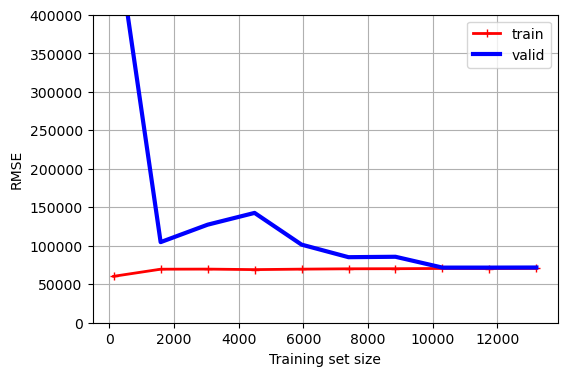

In [54]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, X, y, train_sizes=np.linspace(0.01, 1.0, 10), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None,None, 0,400000]) 
plt.show()

Learning curve for polynomial regression:

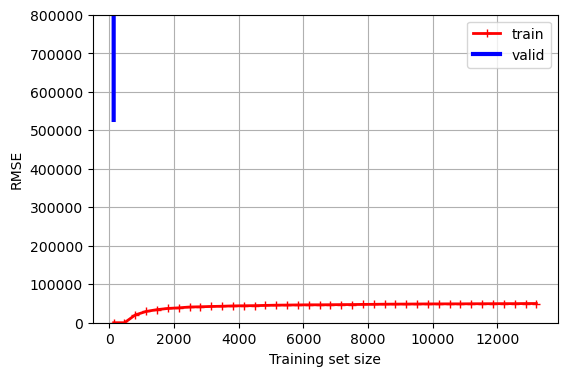

In [55]:
train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, X_poly, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None,None, 0,800000]) 
plt.show()

Learning curve for ridge regression:

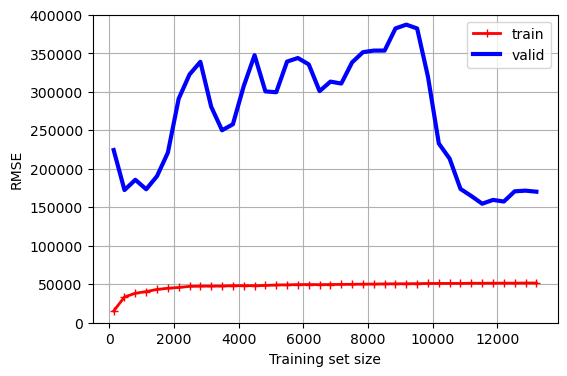

In [56]:
train_sizes, train_scores, valid_scores = learning_curve(
    ridge_reg, X_poly, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None,None, 0,400000]) 
plt.show()

- Comment: Looking at the learning curve for the full training set size:

    - Linear regression is giving the best fit here, not overfitting, and relative to the 3 models being compared it is also not underfitting: ~70K RMSE on the validation set and the same on the training dataset
    - Polynomial regression is extremely overfitting. RMSE on the validation set is off the sacle.
    - Ridge regression is overfitting: ~150K RMSE on the validation set but lower RMSE of 50K on the training set.

- Additional remarks:
    
    - By increasing `alpha`, the validation RMSE can be brought down to the training set RMSE of 50K, removing the overfitting and making it better than regression.
    - The erratic behavior of the learning curves can be removed by adding `drop="first"` to the one-hot encoder., as a consequence of two factors:
        -  Firstly, instances where `ocean_proximity=ISLAND` are rare, and for small training set sizes they may not appear in the training data but do appear in the validation data, so the coefficient of this category cannot
        - Secondly, this combined with one-hot encoding creating collinear dummy variables will cause the predictions of `ocean_proximity=ISLAND` instances to behave erratically over different training data with predictions giving huge values in the order of 1e32.
    - Since the dummy variables are collinear, there is no unique solution to the linear regression fit. This does not usually affect predictions when the categories for `ocean_proximity` on the training set and the validation set are the same but introduces a degree of freedom when one of the categories (ISLAND) cannot be estimated on the training set which is causing these very erratic predictions.
    - The solution to this problem is to drop one of the one-hot encoding dummy variables to remove collinearity so that there is a unique solution again. This is specific to unregularized linear regression. Alternatively, using regularization (such as ridge, as seen above) also fixes the problem. When doing this, dropping a dummy variable should be avoided (dropping a dummy puts the effect of that variable into the intercept, but the intercept is not regularized, while all other categories of the variable will be, and this should be avoided since this treats that category differently from the rest).

- A brief note about this is mentioned under the drop argument in the [OneHotEncoder documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [57]:
cat_pipeline_drop = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # Optional: imputes missing (but there are none)
    OneHotEncoder(handle_unknown="ignore", drop="first"))

preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline_drop, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column 

X = preprocessing.fit_transform(X_raw)

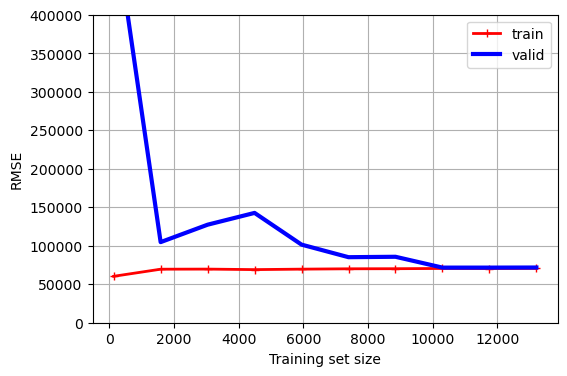

In [58]:
train_sizes, train_scores, valid_scores = learning_curve(
    lin_reg, X, y, train_sizes=np.linspace(0.01, 1.0, 10), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([None,None, 0,400000]) 
plt.show()

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [59]:
import os
import pandas as pd
data = pd.read_csv("datasets\Default.csv")

**Solution:**

Create a test set by taking a random 20% sample (it's also fine to do stratified sampling instead).

In [60]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
default = train_set.copy()
default.head()

,default,student,balance,income
9254,No,No,1018.568130,34103.879520
1561,No,No,62.170050,28660.747508
1670,No,No,1046.743543,40822.447413
6087,No,No,763.735280,44125.718725
6669,No,Yes,697.248633,25730.917583


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

In [61]:
default.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  8000 non-null   object 
 1   student  8000 non-null   object 
 2   balance  8000 non-null   float64
 3   income   8000 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.5+ KB


Create the target variable.

In [62]:
y = default["default"].values=="Yes"

Create the features.

In [63]:
X_raw = default.drop("default", axis=1)
X_raw.head()

,student,balance,income
9254,No,1018.568130,34103.879520
1561,No,62.170050,28660.747508
1670,No,1046.743543,40822.447413
6087,No,763.735280,44125.718725
6669,Yes,697.248633,25730.917583


Now create the pipelines. For the numerical features, we use a standard scaler. For the categorical features, we use one-hot encoding.

In [64]:
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer([
        ("num", StandardScaler(), make_column_selector(dtype_include=float)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ])

In [65]:
X = preprocessing.fit_transform(X_raw)

In [66]:
X

array([[ 0.38108223,  0.03730779,  1.        ,  0.        ],
       [-1.59177438, -0.37009867,  1.        ,  0.        ],
       [ 0.43920243,  0.54017781,  1.        ,  0.        ],
       ...,
       [-0.23061793, -0.49558035,  1.        ,  0.        ],
       [-1.38184384, -0.93727606,  0.        ,  1.        ],
       [-0.40531852,  1.20145415,  1.        ,  0.        ]],
      shape=(8000, 4))

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

In [67]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression() # setting random seed has no effect with the default solver
logistic.fit(X, y)

LogisticRegression()

Next, fit the SGD classifier model.

In [68]:
from sklearn.linear_model import SGDClassifier
SGDclf = SGDClassifier(random_state=42)
SGDclf.fit(X, y)

SGDClassifier(random_state=42)

Now compute the scores of each instance using 10-fold CV.

In [69]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict


# Logistic regression score
y_scores_logistic = cross_val_predict(logistic, X, y, cv=10, method="decision_function")
# Note the following is equivalent: 
# y_scores_logistic = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")[:,1]

# SGDClassifier score
y_scores_SGDclf = cross_val_predict(SGDclf, X, y, cv=10, method="decision_function")

Get the FPR and TPR using theroc_curve function and plot the ROC curve.

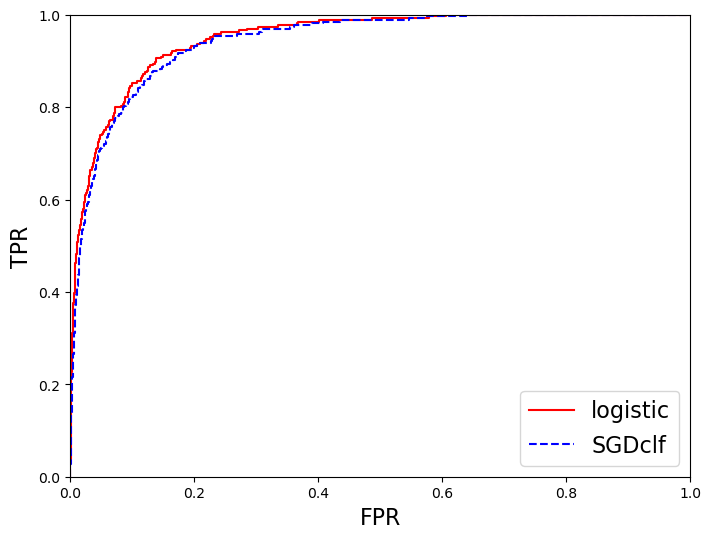

In [70]:
plt.figure(figsize=(8, 6))

# Plot for logistic regression
fpr, tpr, thresholds = roc_curve(y,y_scores_logistic)
plt.plot(fpr, tpr, "r-", label="logistic")

# Plot for SGDClassifier
fpr, tpr, thresholds = roc_curve(y,y_scores_SGDclf)
plt.plot(fpr, tpr, "b--", label="SGDclf")

plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

Compute the ROC AUC

In [71]:
from sklearn.metrics import roc_auc_score

print("ROC AUC logistic:",roc_auc_score(y, y_scores_logistic))
print("ROC AUC SGDclf:",roc_auc_score(y, y_scores_SGDclf))

ROC AUC logistic: 0.9501484597787597
ROC AUC SGDclf: 0.9433360557488014


To check the out-of-sample ROC AUC for different value of C. There are two methods. Method 1: Single ROC AUC based of out-of-sample decision function for every observation.

In [72]:
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logistic_tmp = LogisticRegression(C=C)
    logistic_tmp.fit(X, y)
    y_scores_logistic = cross_val_predict(logistic_tmp, X, y, cv=10, method="decision_function")
    print("C:",C)
    print("ROC AUC logistic:",roc_auc_score(y, y_scores_logistic))

C: 0.001
ROC AUC logistic: 0.9466421257560089
C: 0.01
ROC AUC logistic: 0.950011359719219
C: 0.1
ROC AUC logistic: 0.9502865391244399
C: 1
ROC AUC logistic: 0.9501484597787597
C: 10
ROC AUC logistic: 0.9501714730030397
C: 100
ROC AUC logistic: 0.9501651076431326


Method 2: Grid search. Average of 10 ROC AUC based of out-of-sample decision function for observations on each CV fold.

In [73]:
param_grid = [
    {'C': [ 0.001, 0.01, 0.1, 1, 10, 100]},
  ]
grid_search = GridSearchCV(logistic, param_grid, cv=10,
                           scoring='roc_auc',
                           n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='roc_auc')

In [74]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False)
cv_res = cv_res[["param_C", "mean_test_score"]]
cv_res

,param_C,mean_test_score
0,0.001,0.947156
1,0.010,0.950528
2,0.100,0.951047
3,1.000,0.951213
4,10.000,0.951198
5,100.000,0.951188


We see that C taking values 0.1, 1, 10, 100 all seem to give the same ROC AUC: ~0.951. C=1 has the best score here.

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

For logistic regression the following uses the scores computed in (c) to obtain and plot the precision and recall as a function of the decision threshold.

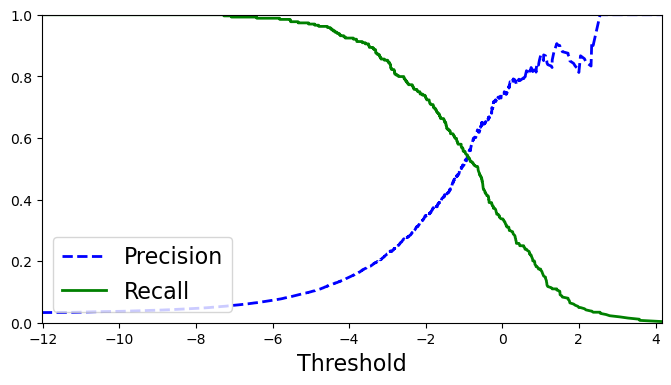

In [75]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
precisions, recalls, thresholds = precision_recall_curve(y,y_scores_logistic)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()

Now compute the threshold that corresponds to at least 75% recall and get the corresponding precision.

In [76]:
ind = np.where(recalls[:-1]>=0.75)[0][-1]
print("Threshold:", thresholds[ind], "\nPrecision:", precisions[:-1][ind], "\nRecall:", recalls[:-1][ind])
opt_threshold_1 = thresholds[ind]
precision_1 = precisions[:-1][ind]

Threshold: -2.1529801402775557 
Precision: 0.32459016393442625 
Recall: 0.75


Model 2:

Repeat for the SGD classifier.

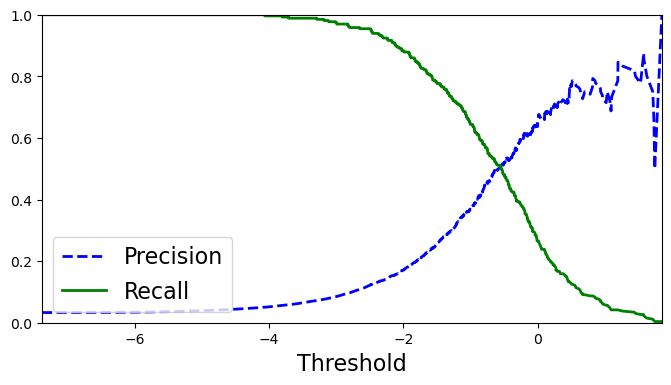

Threshold: -1.3484894484634338 
Precision: 0.2877906976744186 
Recall: 0.75


In [77]:
plt.figure(figsize=(8, 4))
precisions, recalls, thresholds = precision_recall_curve(y,y_scores_SGDclf)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()
ind = np.where(recalls[:-1]>=0.75)[0][-1]
print("Threshold:", thresholds[ind], "\nPrecision:", precisions[:-1][ind], "\nRecall:", recalls[:-1][ind])
opt_threshold_2 = thresholds[ind]
precision_2 = precisions[:-1][ind]

Next, refit the models with class_weight=balanced, calculate the scores (decision function values) again using cross-validation and then repeat to find the threshold and precision for 75% recall. Note that the question does not require a plot for this.

In [78]:
logistic_weights = LogisticRegression(class_weight="balanced")
logistic_weights.fit(X, y)

SGDclf_weights = SGDClassifier(class_weight="balanced",random_state=42)
SGDclf_weights.fit(X, y)

y_scores_logistic = cross_val_predict(logistic_weights, X, y, cv=10, method="decision_function")
y_scores_SGDclf = cross_val_predict(SGDclf_weights, X, y, cv=10, method="decision_function")

Model 3:

Logistic regression with balanced weights

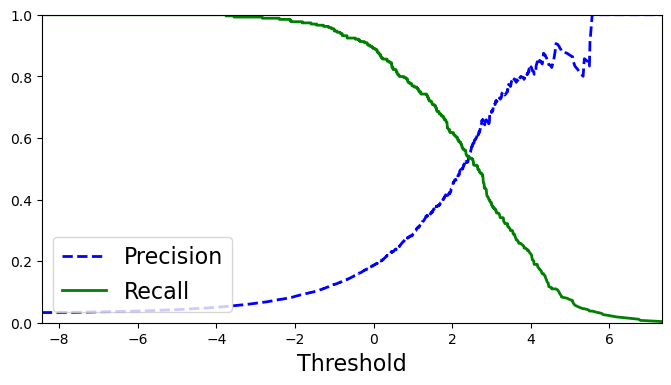

Threshold: 1.2004367837009167 
Precision: 0.3209076175040519 
Recall: 0.75


In [79]:
plt.figure(figsize=(8, 4))
precisions, recalls, thresholds = precision_recall_curve(y,y_scores_logistic)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()
ind = np.where(recalls[:-1]>=0.75)[0][-1]
print("Threshold:", thresholds[ind], "\nPrecision:", precisions[:-1][ind], "\nRecall:", recalls[:-1][ind])
opt_threshold_3 = thresholds[ind]
precision_3 = precisions[:-1][ind]

Model 4:

SGD classifier with balanced weights

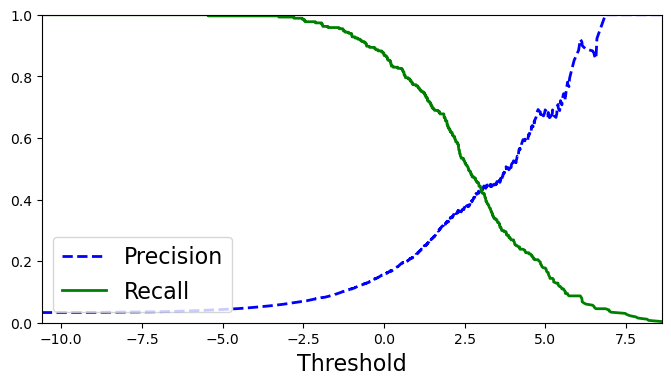

Threshold: 1.2173256283076297 
Precision: 0.24504950495049505 
Recall: 0.75


In [80]:
plt.figure(figsize=(8, 4))
precisions, recalls, thresholds = precision_recall_curve(y,y_scores_SGDclf)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()
ind = np.where(recalls[:-1]>=0.75)[0][-1]
print("Threshold:", thresholds[ind], "\nPrecision:", precisions[:-1][ind], "\nRecall:", recalls[:-1][ind])
opt_threshold_4 = thresholds[ind]
precision_4 = precisions[:-1][ind]

The highest precision corresponding to 75% recall is obtain by Model 1 (32.3%), i.e. logistic regression without `class_weight="balanced"`.

Additional comments: Thus, if it is required that 75% of people default are correctly classified as defaulting, then there is overclassification in the sense that only 32.3% of those classified as default are actually correct (according to an out-of-sample estimate on the training set, next we apply this to the test set).

The balanced weighting (using inverse probability weights $1/\pi_m$, where $\pi_m$ are the probabilities of selecting an instance in each class with a simple random sample) doesn't change the results by much. The results can be improved a bit using undersampling with weights $(1/\pi_m)^a$ for some hyperparameter $a\in (0,1)$.

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**

Get the test set

In [81]:
y_test = test_set["default"].values=="Yes"
X_test_raw = test_set.drop("default", axis=1)
X_test = preprocessing.transform(X_test_raw)

Note that:
    - logistic regression without class_weight="balanced" is used here since it is the best model.
    - we need to use the threshold for prediction, and not the default ``.predict()`` method since we want 75% recall. The threshold is the following.

In [82]:
opt_threshold = opt_threshold_1
# Fit model on training
best_model = logistic

Finally, compute the accuracy, precision, recall, and ROC AUC, respectively.

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Scores
y_scores = best_model.decision_function(X_test)
# The following is equivelent provided that the threshold was computed in this way in (d):
# y_scores = best_model.predict_proba(X_test)[:,1]

# Predict on test
y_pred = y_scores > opt_threshold

# Compute performance measures
[accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    roc_auc_score(y_test, y_scores)]

[0.9325,
 0.28846153846153844,
 0.6521739130434783,
 np.float64(0.9434925209585783)]

Here is the ROC curve.

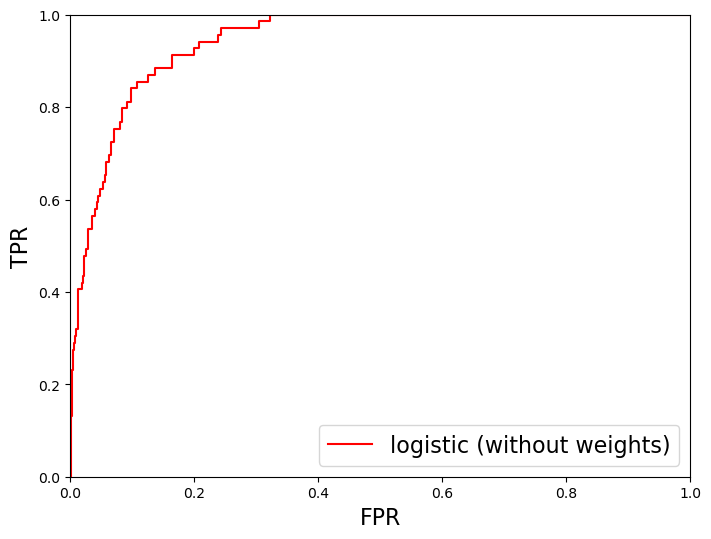

In [84]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test,y_scores)
plt.plot(fpr, tpr, "r-", label="logistic (without weights)")
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()